# Understanding Effectvie Parameter Behavior

In this tutorial we will create a dot array object instances which imports
pre-calculated effective parameter interpolators. We will use the interpolators to 
explore how the effectvice parameters of a quantum dot system change with 
externally varied control parameters i.e. gate voltage or applied RF field.

See 2-qubit tutorial for more detailed explanations on dot array class usage. 

In [1]:
import os
from pathlib import Path
path = Path(os.getcwd())

# update base working directory to QuDiPy
if path.stem != 'QuDiPy':
    base_dir = path.parents[1]
    os.chdir(base_dir)
else:
    base_dir = path

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from qudipy.system import DotArray

Define variables to initialize Dots object instance.

In [3]:
nav_dir = os.path.join('QuDiPy data', 'tutorials')
processed_dir = os.path.join(base_dir, nav_dir,
                            'processed','3QD_processed')
nextnano_dir = os.path.join(base_dir, nav_dir,
                                    'nextnano','3QD')
n_dots = 3      # anticipated number of dots
file_prefix = 'tutorial'

Define control parameters to use when interpolating the potential data from nextnano: must be a subset of the raw data. 

In this example, we choose the control parameters associated with a pre-calculated
data set.

In [4]:
pts = [4,3,4,3,4]
ctrl_vals = [ 
    np.linspace(0.2, 0.35, pts[0]),
    np.linspace(0.0, 0.15, pts[1]),
    np.linspace(0.2, 0.35, pts[2]),
    np.linspace(0.0, 0.15, pts[3]),
    np.linspace(0.2, 0.35, pts[4])]

Create object instance 

In [5]:
dots = DotArray(n_dots, ctrl_ranges=ctrl_vals)
dots.numeric(processed_dir, nextnano_dir, file_prefix)

Loading pre-calculated spin interpolators from
/home/zach/Documents/github/QuDiPy/QuDiPy data/tutorials/processed/3QD_processed/tutorial_spin_data_size_[4 3 4 3 4]_from_[0.2 0.  0.2 0.  0.2]_to_[0.35 0.15 0.35 0.15 0.35].pkl


## 1.3 Test dot splitting

The splitting procedure creates a list of new Dots objects. 
They inherit all properties from the parent object _except_:
1. potential interpolator
`dots_object.potential(ctrl_vals)` now outputs masked potential
2. the positions of visible dots __*(counted from 1)*__ may change.

Splitting group can be either `'single'`/`'singles'` (default) for individual dots, 
or `'pair'`/`'pairs'` for adjacent pairs.


> **Note**: if the number of quantum dots decreases for any control value coordinates, then the potential landscape returns `NaN`s, since the quantum dot system must be dot invariant for the present applications. 

> `NaN`s are not displayed when plotting

[-3.5539419315280603e-19, -3.4428508389180723e-19]


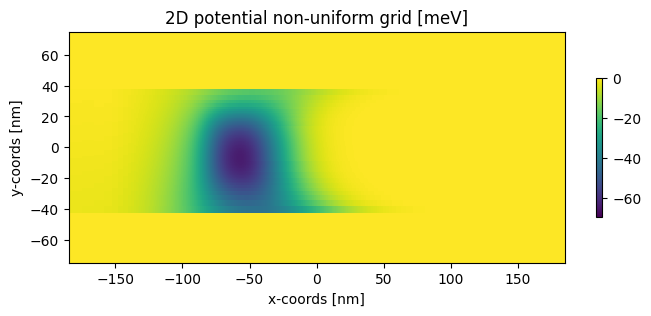

In [6]:
# Choose voltage control values
voltage_config = [0.2,0.0,0.2,0.0,0.2]
voltage_config = [0.2,0.0,0.2,0.0,0.2]

# dot1, dot2 = dots.split(group='single')
dot1, dot2, dot3 = dots.split(group='single')
dotpair1, dotpair2 = dots.split(group='pair')

# dots.potential.plot(voltage_config)

u_max = np.max(dots.potential(voltage_config))
u_min = np.min(dots.potential(voltage_config))
cbar_bounds=[u_min, u_max]
print(cbar_bounds)

# # TODO: add error handling message for wrong number of non-sigleton gates
# print('Visible dots:\t', dot1.visible_dots)
dot1.potential.plot(voltage_config, cbar_pot=cbar_bounds)

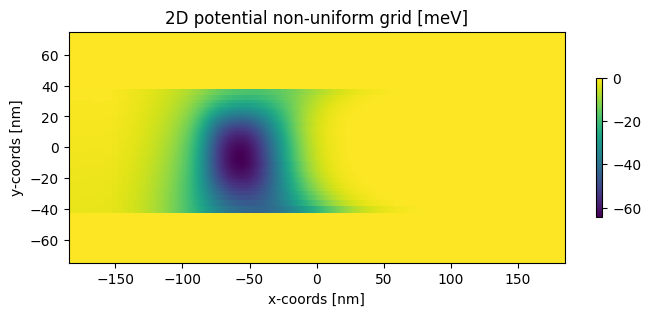

In [7]:
dot2.potential.plot(voltage_config, cbar_min=u_min, cbar_max=u_max)

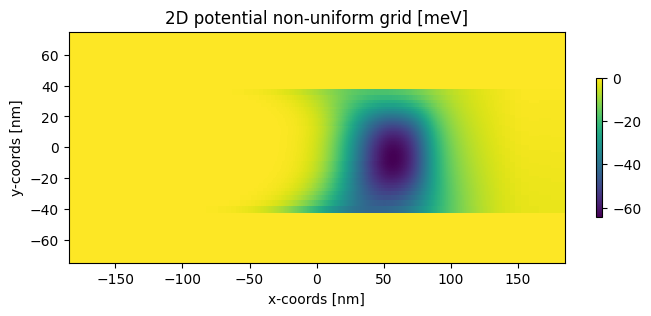

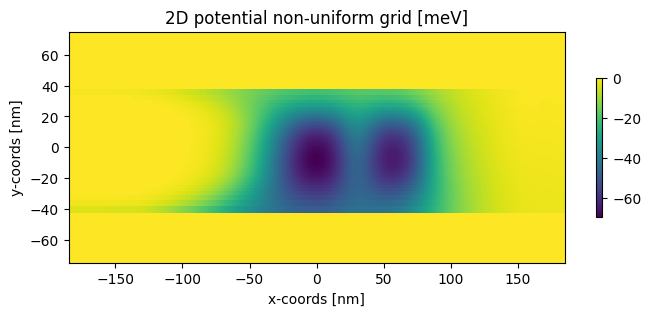

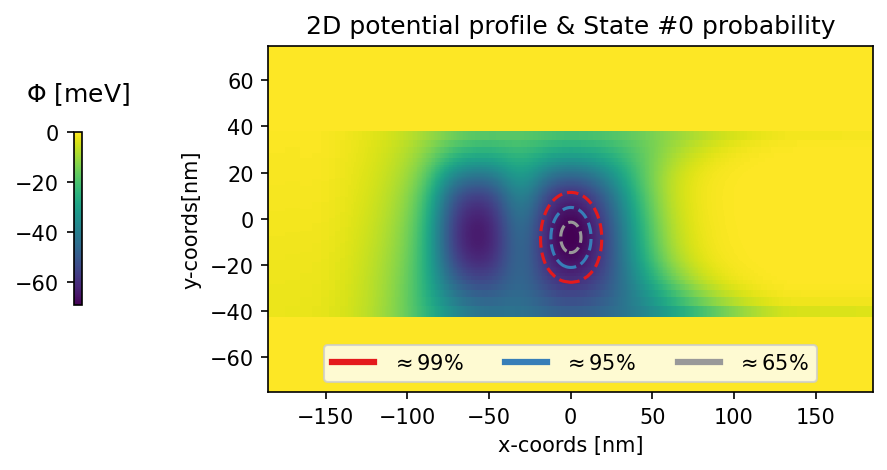

In [8]:
dot3.potential.plot(voltage_config, cbar_min=u_min, cbar_max=u_max)
dotpair2.potential.plot(voltage_config, cbar_min=u_min, cbar_max=u_max)
dotpair1.potential.plot(voltage_config, cbar_min=u_min, cbar_max=u_max, show_wf=True)

## Effective Parameter Relationships

First we define a range of control voltage values to plot the effective parameter relationships.

It is assumed that the order of the control variables is:

```
V_range = [V1_range, W1_range, V2_range, ..., Wn_range, Vn_range]
```

Where the range variables define the start and end voltage values, e.g. 

```
V1_range = [0.2, 0.3]
```

One voltage is swept at a time, \# of points per sweep is specified with `n_sweep_pts`.

The initial configuration (determines the unchanging voltages) is defined by 
``
init_config.
``
When unspecified, it corresponds to the _minimum_ values of each voltage in the range.

In [9]:
ctrl_range = [[0.2,0.3], [0.0,0.1], [0.2,0.3], [0.0,0.1], [0.2,0.3]]

## Plotting effective parameters vs voltage

Exchange Energy

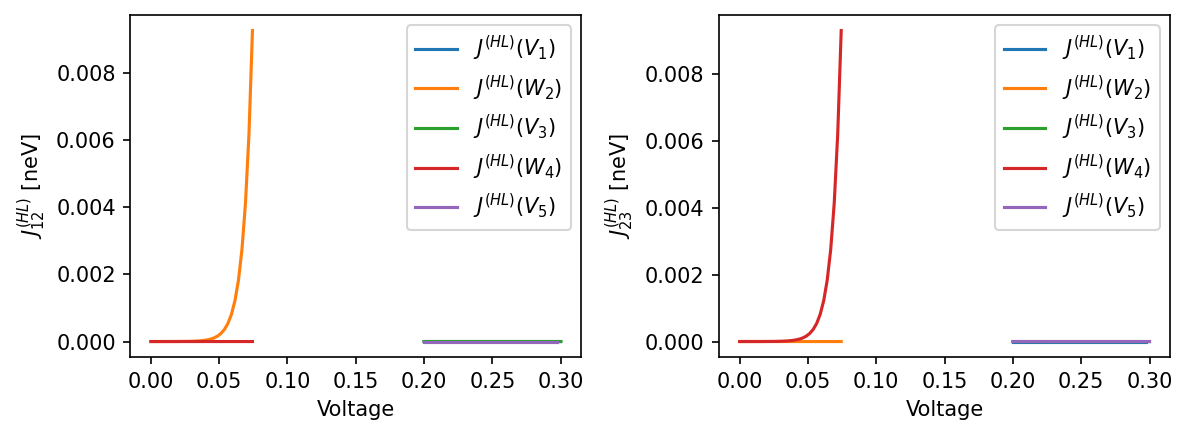

In [10]:
dots.plot_sweep(ctrl_range, param='HL', ex_units='neV')

Exchange Energy on Log Scale &  with a different initial configuration

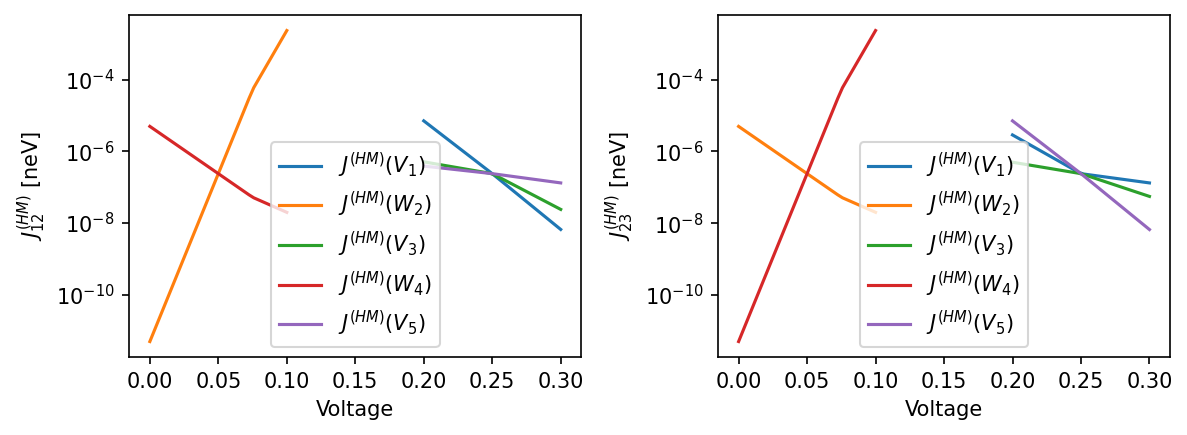

In [11]:
init_voltages = [0.25, 0.05, 0.25, 0.05, 0.25]
dots.plot_sweep(ctrl_range, param='exchange_HM', init_config=init_voltages, 
                ex_units='neV', yscale='log', n_sweep_pts=30)

G-factor

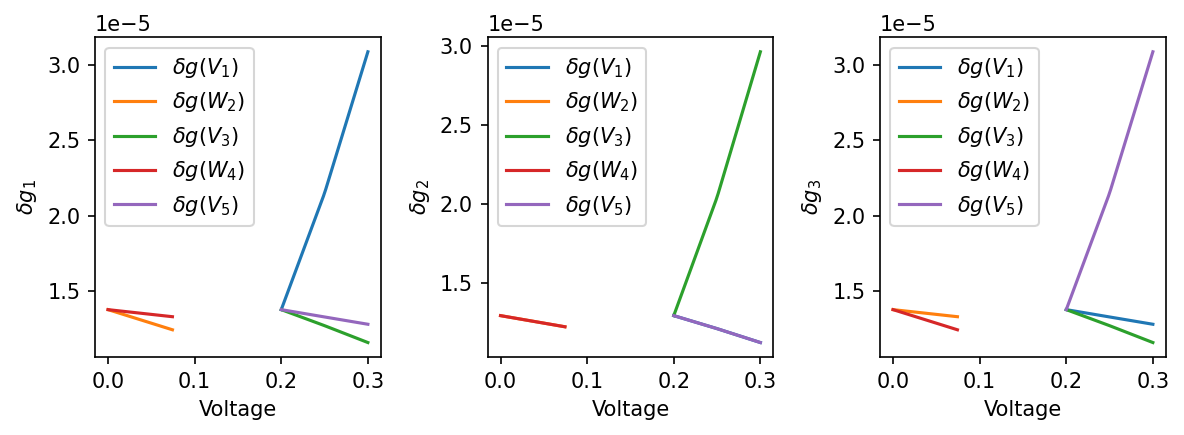

In [12]:
dots.plot_sweep(ctrl_range, param='g_factor')

## Track field information and wave function for gate sweep

Now we plot how the electric and potential field changes with gate voltage 
along with the change in the ground state wavefunction. 

In [13]:
import qudipy.potential as pt
import qudipy.qutils as qt

from qudipy.qutils.math import inner_prod
from qudipy.utils import constants

consts = constants.select_material('Si/SiO2')

g-factor decrease due to lateral dot shifts

/home/zach/anaconda3/envs/qudipy/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


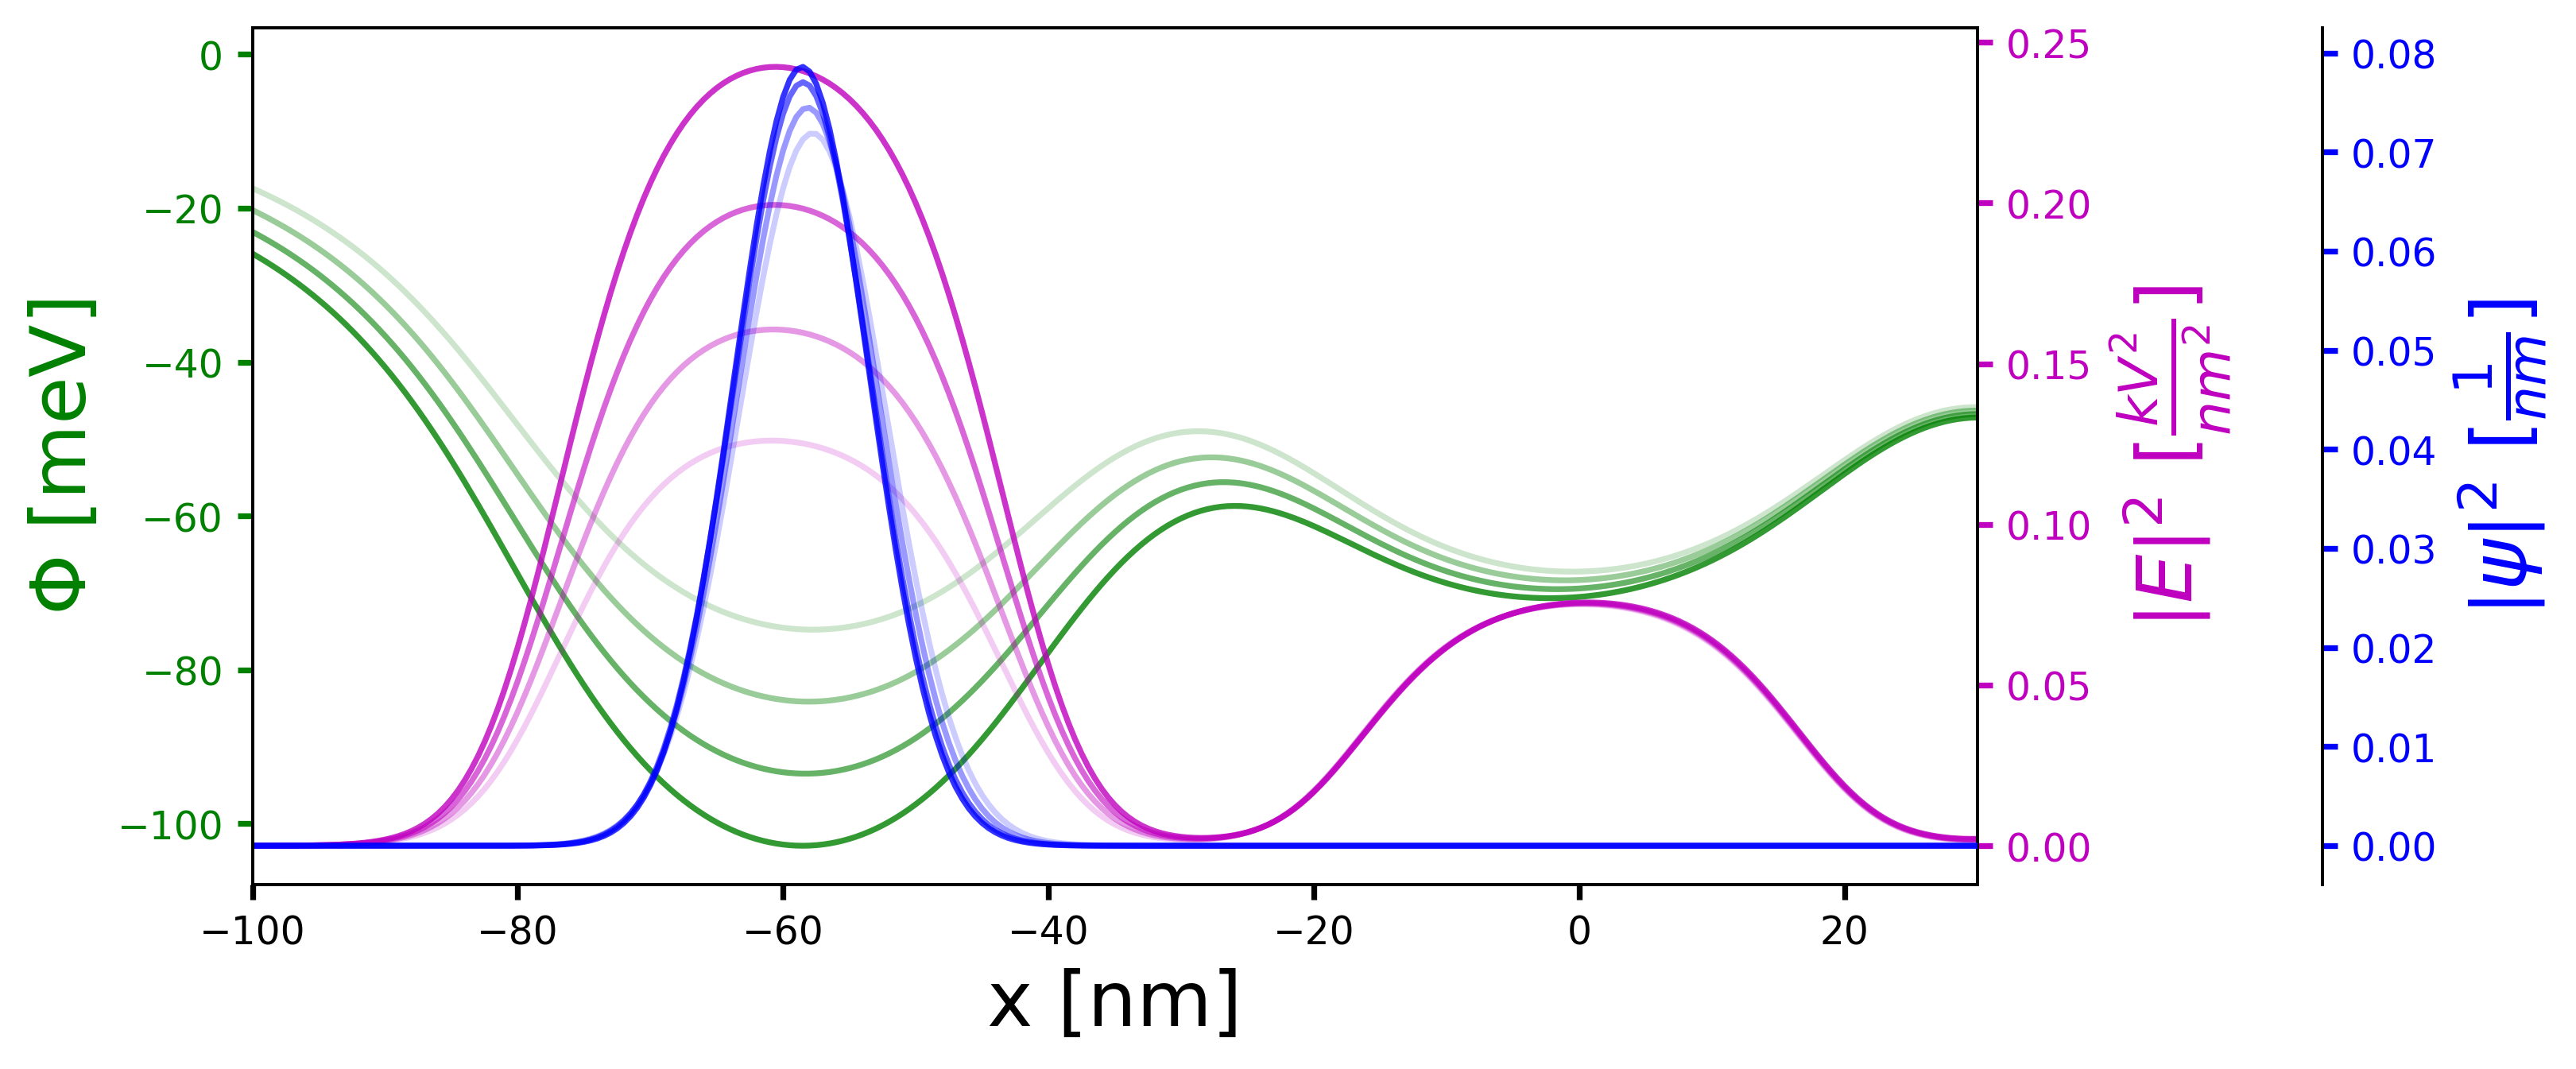

In [14]:
voltage_config = [0.2,0.0,0.35,0.0,0.2]

field_units = 1e-7 # kV/cm -> kV/nm
pot_units = 1/1.622e-19*1e3 # V -> meV
coord_units = 1e9 # m -> nm
wave_units = 1e-9 # 1/m -> 1/nm

pot = dot2.potential(voltage_config)
pot_slice = pot[60,:]
x = dots.x
y = dots.y

gparams = pt.GridParameters(x, potential=pot_slice)
e_ens, e_vecs = qt.solvers.solve_schrodinger_eq(consts, gparams, n_sols=6)

steps = 5
v = np.linspace(0.218,0.35, steps)
fig, ax = plt.subplots(figsize=(8,4), dpi=350)
ax3 = ax.twinx()
ax6 = ax.twinx()

for idx, volt in  enumerate(v):
    voltage_config = [volt,0.0,0.2,0.0,0.218]
    

    pot = dots.potential(voltage_config)
    pot_masked = dot2.potential(voltage_config)
    field = dots.e_field(voltage_config)
    field_masked = dot2.e_field(voltage_config)

    e_max = np.max(field)
    p_max = np.max(pot)
    pot -= p_max
    field -= e_max

    pot_slice = pot[60]
    pot_masked_slice = pot_masked[60]
    field_masked_slice = field_masked[60]
    field_slice = field[60]

    # get wave function
    gparams = pt.GridParameters(x, potential=pot_masked_slice)
    e_ens, e_vecs = qt.solvers.solve_schrodinger_eq(consts, gparams, n_sols=6)
    wavefunc = e_vecs[:,0]

    # compute weighted average
    weighted_wavefunc = np.square(field_masked_slice) * wavefunc
    exp_val = inner_prod(gparams, wavefunc, weighted_wavefunc)
    
    phi, = ax.plot(x*coord_units, pot_slice * pot_units, '-g', alpha=idx/steps)
    E, = ax3.plot(x*coord_units, np.square(field_slice * field_units), '-m', alpha=idx/steps)

    psi, = ax6.plot(x*coord_units,np.multiply(np.conj(wavefunc), wavefunc) * wave_units, '-b', alpha=idx/steps)

font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 20,
        }

ax.set_ylabel('$\Phi$ [meV]', fontdict=font)
ax3.set_ylabel('$|E|^{2} \ [\\frac{kV^{2}}{nm^{2}}]$', fontdict=font)
ax6.set_ylabel('Re$ ( \psi ) \ [ \\frac{1}{\sqrt{nm}} ]$', fontdict=font)
ax6.set_ylabel('$| \psi |^2 \ [ \\frac{1}{nm} ]$', fontdict=font)
ax.set_xlabel('x [nm]', fontdict=font)

xlim_l = -100
xlim_r = 30
ax.set_xlim([xlim_l,xlim_r])
ax3.set_xlim([xlim_l,xlim_r])
ax6.set_xlim([xlim_l,xlim_r])
ax6.spines.right.set_position(("axes", 1.2))

# colors 
ax.yaxis.label.set_color(phi.get_color())
ax3.yaxis.label.set_color(E.get_color())
ax6.yaxis.label.set_color(psi.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=phi.get_color(), **tkw)
ax3.tick_params(axis='y', colors=E.get_color(), **tkw)
ax6.tick_params(axis='y', colors=psi.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

Text(0.5, 0, 'x [nm]')

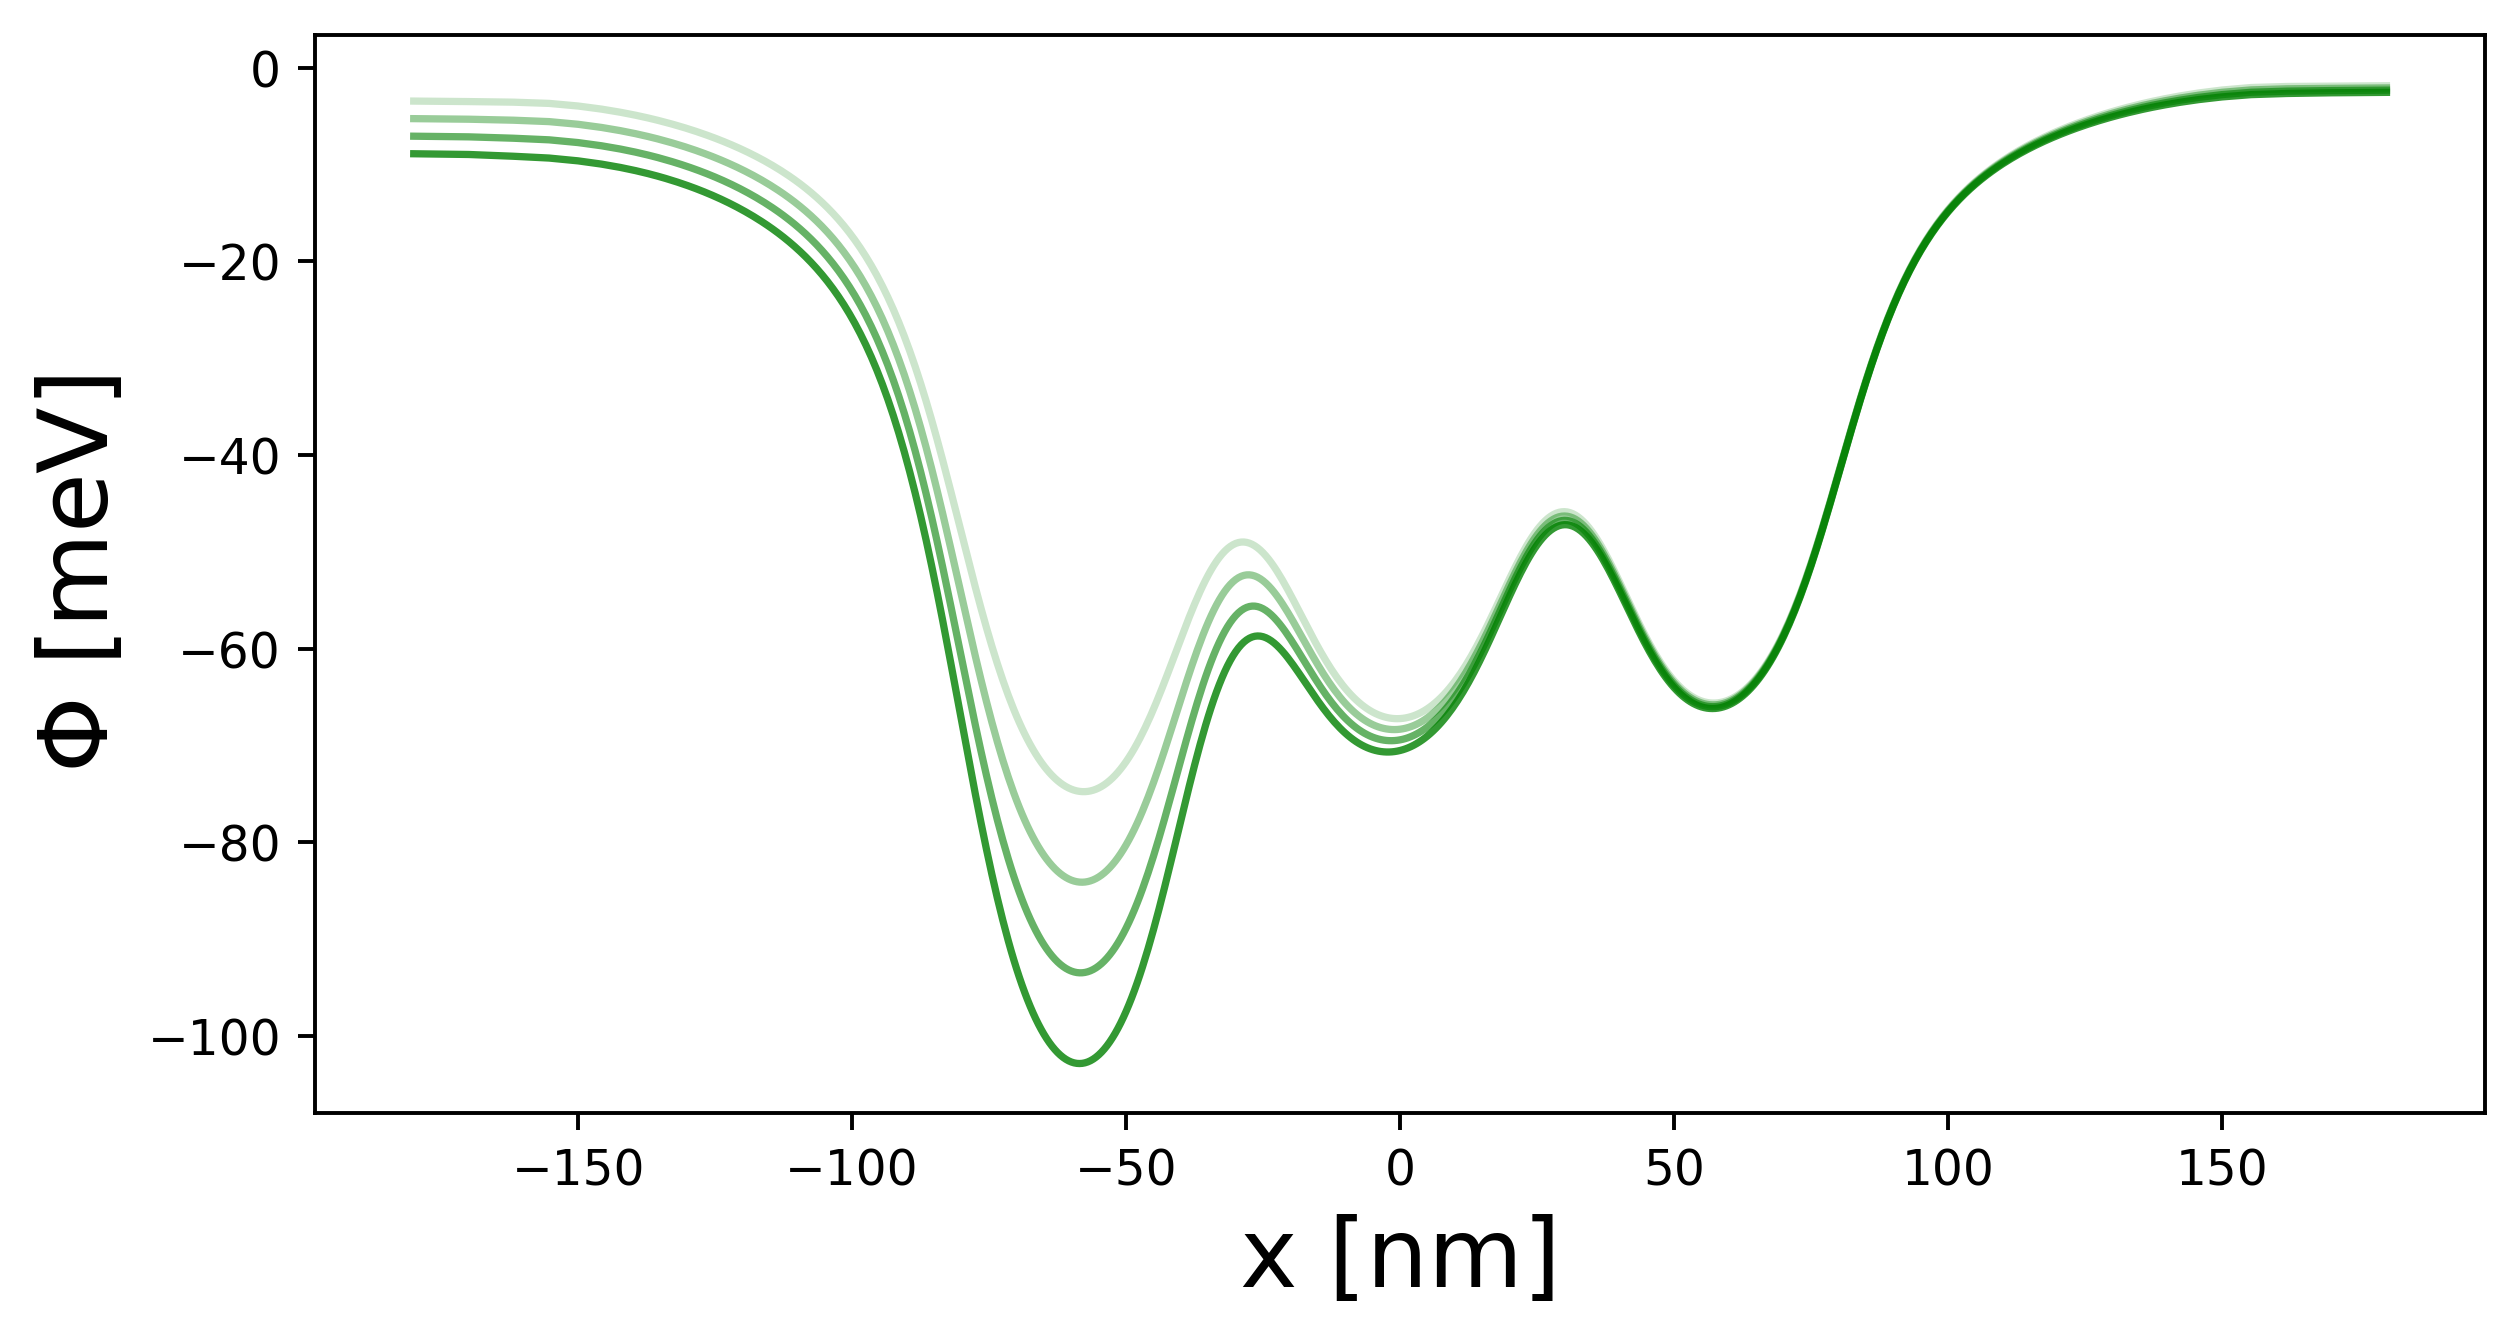

In [15]:
voltage_config = [0.2,0.0,0.35,0.0,0.2]

field_units = 1e-7 # kV/cm -> kV/nm
pot_units = 1/1.622e-19*1e3 # V -> meV
coord_units = 1e9 # m -> nm
wave_units = 1e-9 # 1/m -> 1/nm

pot = dot2.potential(voltage_config)
pot_slice = pot[60,:]
x = dots.x
y = dots.y

steps = 5
v = np.linspace(0.218,0.35, steps)
fig, ax = plt.subplots(figsize=(8,4), dpi=350)

for idx, volt in  enumerate(v):
    voltage_config = [volt,0.0,0.2,0.0,0.218]
    

    pot = dots.potential(voltage_config)
    pot_masked = dot2.potential(voltage_config)
    field = dots.e_field(voltage_config)
    field_masked = dot2.e_field(voltage_config)

    e_max = np.max(field)
    p_max = np.max(pot)
    pot -= p_max
    field -= e_max

    pot_slice = pot[60]
    pot_masked_slice = pot_masked[60]

    phi, = ax.plot(x*coord_units, pot_slice * pot_units, '-g', alpha=idx/steps)

font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 20,
        }

ax.set_ylabel('$\Phi$ [meV]', fontdict=font)
ax.set_xlabel('x [nm]', fontdict=font)

Exchange between pair of dots due to barrier gate adjacent to the dots

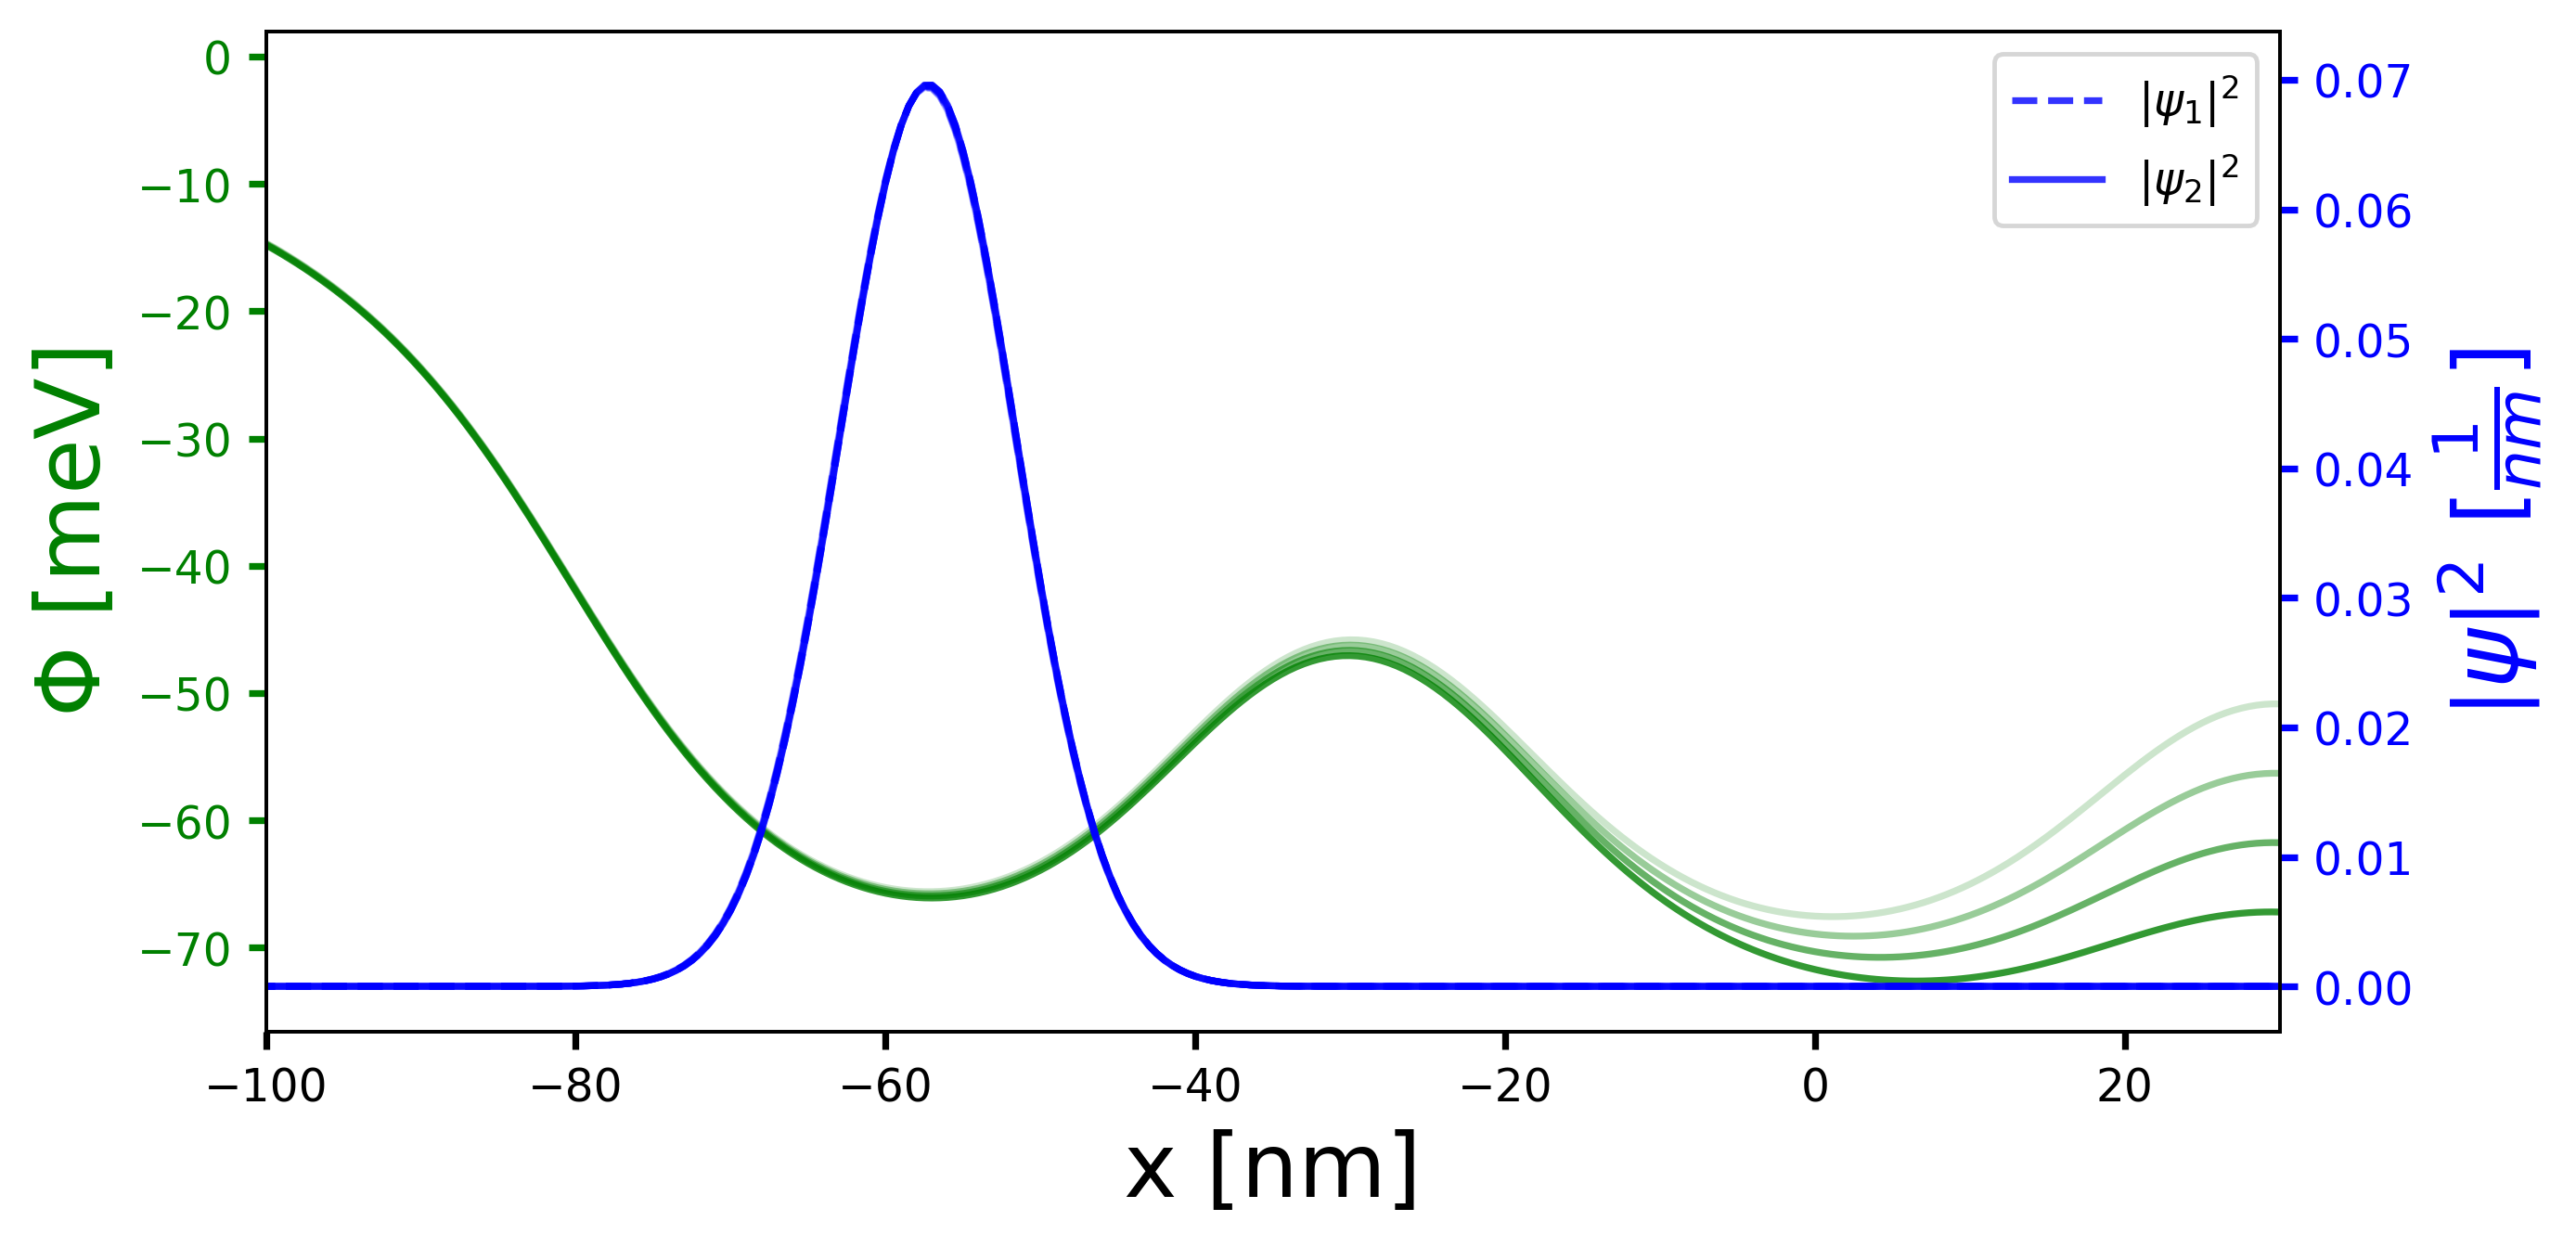

In [16]:
voltage_config = [0.2,0.0,0.35,0.0,0.2]

field_units = 1e-7 # kV/cm -> kV/nm
# field_units = 1e-8 # kV/cm -> kV/A
pot_units = 1/1.622e-19*1e3 # V -> meV
coord_units = 1e9 # m -> nm
wave_units = 1e-9 # 1/m -> 1/nm

pot = dot2.potential(voltage_config)
pot_slice = pot[60,:]
x = dots.x
y = dots.y

gparams = pt.GridParameters(x, potential=pot_slice)
e_ens, e_vecs = qt.solvers.solve_schrodinger_eq(consts, gparams, n_sols=6)

steps = 5
v = np.linspace(0,0.125, steps)
fig, ax = plt.subplots(figsize=(8,4), dpi=350)
ax3 = ax.twinx()

for idx, volt in  enumerate(v):
    voltage_config = [0.218,volt,0.2,0.0,0.218]
    voltage_config = [0.218,0.0,0.2,volt,0.218]
    

    pot = dots.potential(voltage_config)
    pot_masked_r = dot2.potential(voltage_config)
    pot_masked_l = dot1.potential(voltage_config)
    field = dots.e_field(voltage_config)
    field_masked = dot2.e_field(voltage_config)

    e_max = np.max(field)
    p_max = np.max(pot)
    pot -= p_max
    field -= e_max

    pot_slice = pot[60]
    pot_masked_slice_r = pot_masked_r[60]
    pot_masked_slice_l = pot_masked_l[60]
    field_masked_slice = field_masked[60]
    field_slice = field[60]

    # get wave function
    gparams_r = pt.GridParameters(x, potential=pot_masked_slice_r)
    _, e_vecs_r = qt.solvers.solve_schrodinger_eq(consts, gparams_r, n_sols=6)
    wavefunc_r = e_vecs_r[:,0]

    gparams_l = pt.GridParameters(x, potential=pot_masked_slice_l)
    _, e_vecs_l = qt.solvers.solve_schrodinger_eq(consts, gparams_l, n_sols=6)
    wavefunc_l = e_vecs_l[:,0]


    phi, = ax.plot(x*coord_units, pot_slice * pot_units, '-g', alpha=idx/steps)
    # E, = ax3.plot(x*coord_units, np.square(field_slice * field_units), '-m', alpha=idx/steps)

    psir, = ax3.plot(x*coord_units,np.multiply(np.conj(wavefunc_r), wavefunc_r) * wave_units, '-b', alpha=idx/steps, label='$| \psi_2 |^2$')
    psil, = ax3.plot(x*coord_units,np.multiply(np.conj(wavefunc_l), wavefunc_l) * wave_units, '--b', alpha=idx/steps, label='$| \psi_1 |^2$')

font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 20,
        }

ax.set_ylabel('$\Phi$ [meV]', fontdict=font)
ax3.set_ylabel('$| \psi |^2 \ [ \\frac{1}{nm} ]$', fontdict=font)
ax.set_xlabel('x [nm]', fontdict=font)

ax3.legend(handles=[psil, psir])

xlim_l = -100
xlim_r = 30
ax.set_xlim([xlim_l,xlim_r])
ax3.set_xlim([xlim_l,xlim_r])

# colors 
ax.yaxis.label.set_color(phi.get_color())
ax3.yaxis.label.set_color(psir.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=phi.get_color(), **tkw)
ax3.tick_params(axis='y', colors=psir.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

Text(0.5, 0, 'x [nm]')

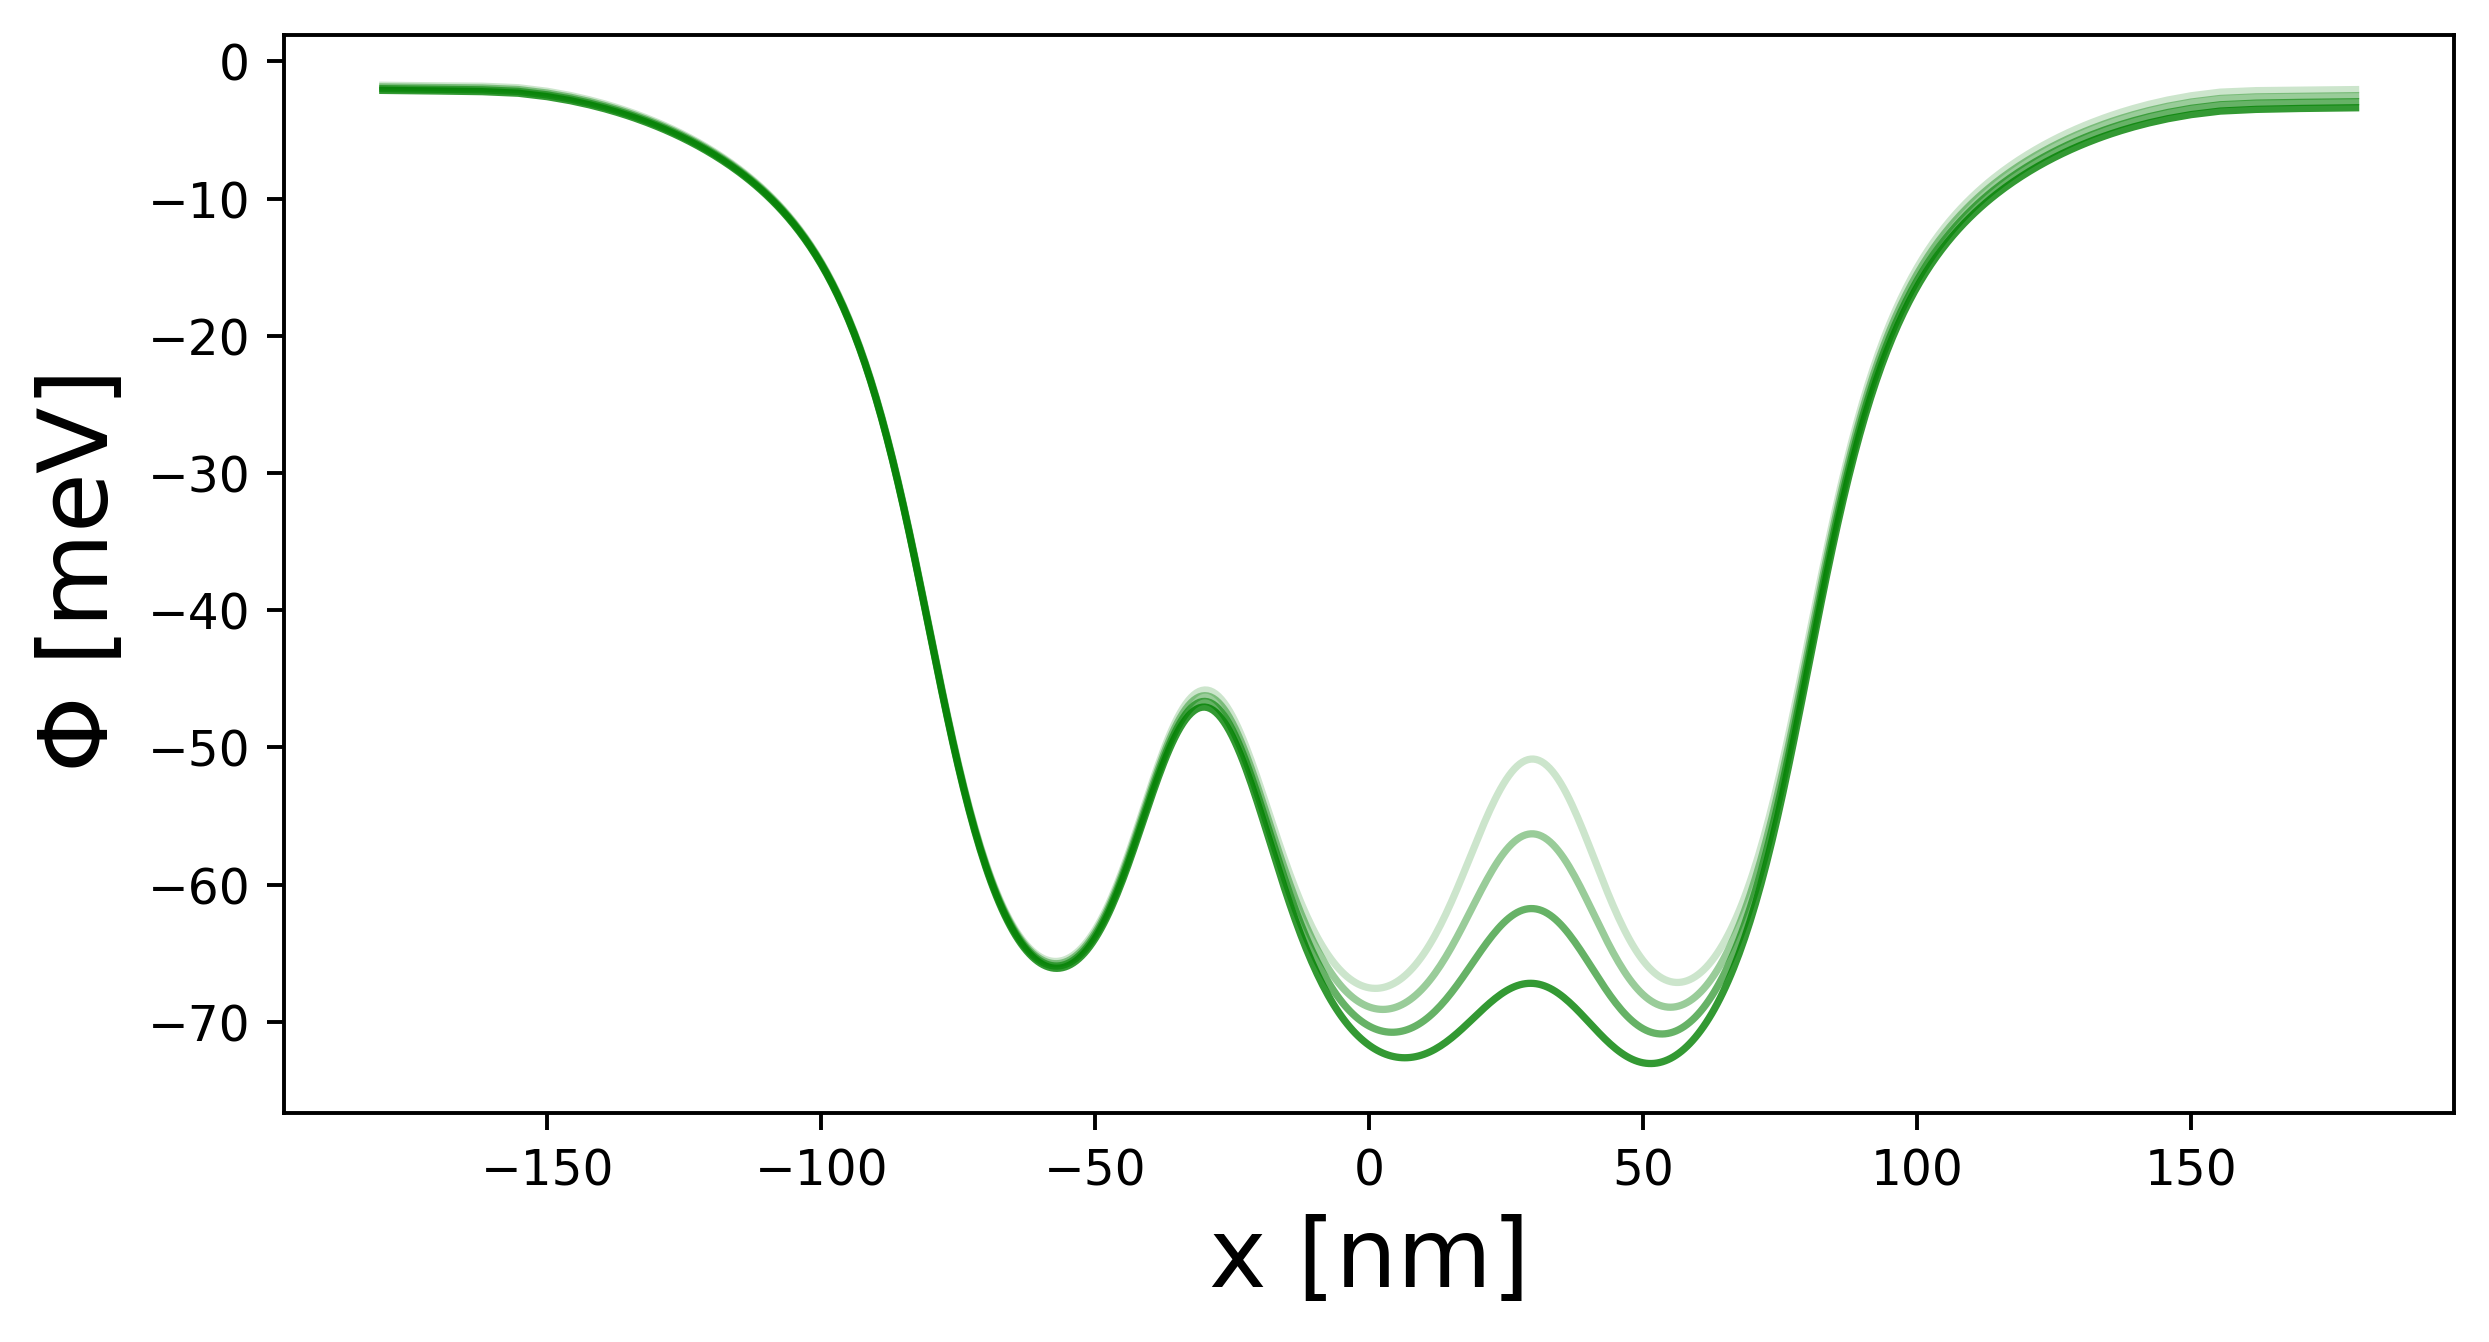

In [17]:
voltage_config = [0.2,0.0,0.35,0.0,0.2]

field_units = 1e-7 # kV/cm -> kV/nm
pot_units = 1/1.622e-19*1e3 # V -> meV
coord_units = 1e9 # m -> nm
wave_units = 1e-9 # 1/m -> 1/nm

pot = dot2.potential(voltage_config)
pot_slice = pot[60,:]
x = dots.x
y = dots.y

steps = 5
v = np.linspace(0,0.125, steps)
fig, ax = plt.subplots(figsize=(8,4), dpi=350)

for idx, volt in  enumerate(v):
    voltage_config = [0.218,volt,0.2,0.0,0.218]
    voltage_config = [0.218,0.0,0.2,volt,0.218]
    

    pot = dots.potential(voltage_config)
    pot_masked = dot2.potential(voltage_config)
    field = dots.e_field(voltage_config)
    field_masked = dot2.e_field(voltage_config)

    e_max = np.max(field)
    p_max = np.max(pot)
    pot -= p_max
    field -= e_max

    pot_slice = pot[60]
    pot_masked_slice = pot_masked[60]

    phi, = ax.plot(x*coord_units, pot_slice * pot_units, '-g', alpha=idx/steps)

font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 20,
        }

ax.set_ylabel('$\Phi$ [meV]', fontdict=font)
ax.set_xlabel('x [nm]', fontdict=font)

Exchange between pair of dots due to barrier gate in between the dots

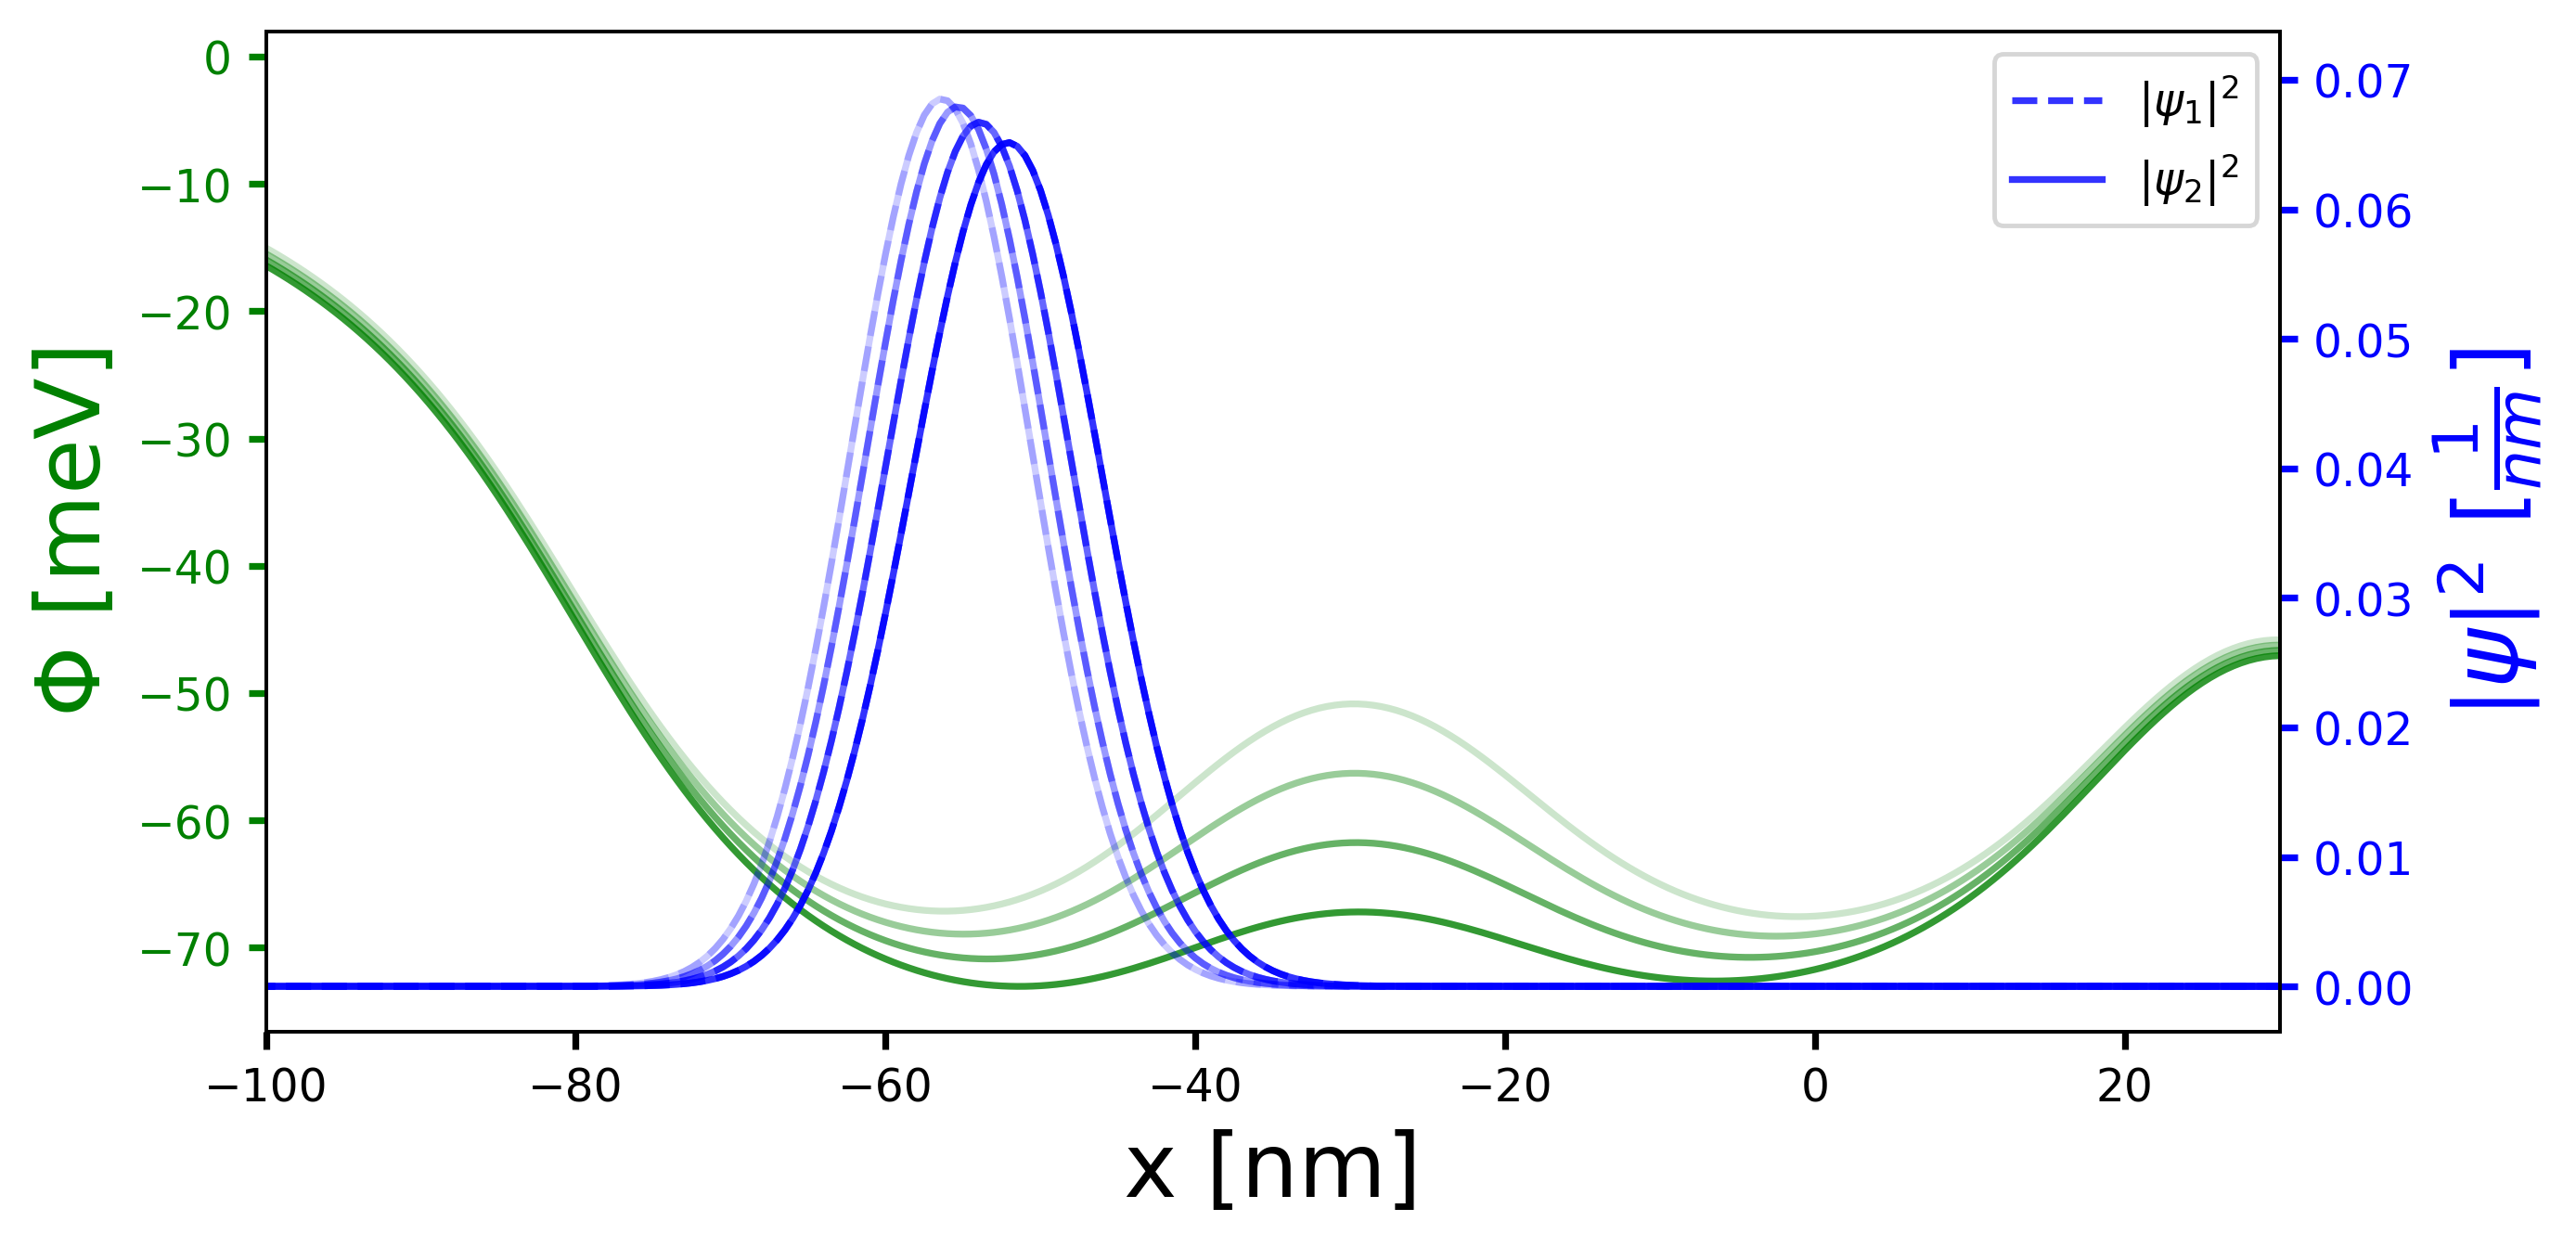

In [18]:
voltage_config = [0.2,0.0,0.35,0.0,0.2]

field_units = 1e-7 # kV/cm -> kV/nm
# field_units = 1e-8 # kV/cm -> kV/A
pot_units = 1/1.622e-19*1e3 # V -> meV
coord_units = 1e9 # m -> nm
wave_units = 1e-9 # 1/m -> 1/nm

pot = dot2.potential(voltage_config)
pot_slice = pot[60,:]
x = dots.x
y = dots.y

gparams = pt.GridParameters(x, potential=pot_slice)
e_ens, e_vecs = qt.solvers.solve_schrodinger_eq(consts, gparams, n_sols=6)

steps = 5
v = np.linspace(0,0.125, steps)
fig, ax = plt.subplots(figsize=(8,4), dpi=350)
ax3 = ax.twinx()

for idx, volt in  enumerate(v):
    voltage_config = [0.218,volt,0.2,0.0,0.218]
    
    pot = dots.potential(voltage_config)
    pot_masked_r = dot2.potential(voltage_config)
    pot_masked_l = dot1.potential(voltage_config)
    field = dots.e_field(voltage_config)
    field_masked = dot2.e_field(voltage_config)

    e_max = np.max(field)
    p_max = np.max(pot)
    pot -= p_max
    field -= e_max

    pot_slice = pot[60]
    pot_masked_slice_r = pot_masked_r[60]
    pot_masked_slice_l = pot_masked_l[60]
    field_masked_slice = field_masked[60]
    field_slice = field[60]

    # get wave function
    gparams_r = pt.GridParameters(x, potential=pot_masked_slice_r)
    _, e_vecs_r = qt.solvers.solve_schrodinger_eq(consts, gparams_r, n_sols=6)
    wavefunc_r = e_vecs_r[:,0]

    gparams_l = pt.GridParameters(x, potential=pot_masked_slice_l)
    _, e_vecs_l = qt.solvers.solve_schrodinger_eq(consts, gparams_l, n_sols=6)
    wavefunc_l = e_vecs_l[:,0]


    phi, = ax.plot(x*coord_units, pot_slice * pot_units, '-g', alpha=idx/steps)
    # E, = ax3.plot(x*coord_units, np.square(field_slice * field_units), '-m', alpha=idx/steps)

    psir, = ax3.plot(x*coord_units,np.multiply(np.conj(wavefunc_r), wavefunc_r) * wave_units, '-b', alpha=idx/steps, label='$| \psi_2 |^2$')
    psil, = ax3.plot(x*coord_units,np.multiply(np.conj(wavefunc_l), wavefunc_l) * wave_units, '--b', alpha=idx/steps, label='$| \psi_1 |^2$')

font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 20,
        }

ax.set_ylabel('$\Phi$ [meV]', fontdict=font)
ax3.set_ylabel('$| \psi |^2 \ [ \\frac{1}{nm} ]$', fontdict=font)
ax.set_xlabel('x [nm]', fontdict=font)

ax3.legend(handles=[psil, psir])

xlim_l = -100
xlim_r = 30
ax.set_xlim([xlim_l,xlim_r])
ax3.set_xlim([xlim_l,xlim_r])

# colors 
ax.yaxis.label.set_color(phi.get_color())
ax3.yaxis.label.set_color(psir.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=phi.get_color(), **tkw)
ax3.tick_params(axis='y', colors=psir.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

Text(0.5, 0, 'x [nm]')

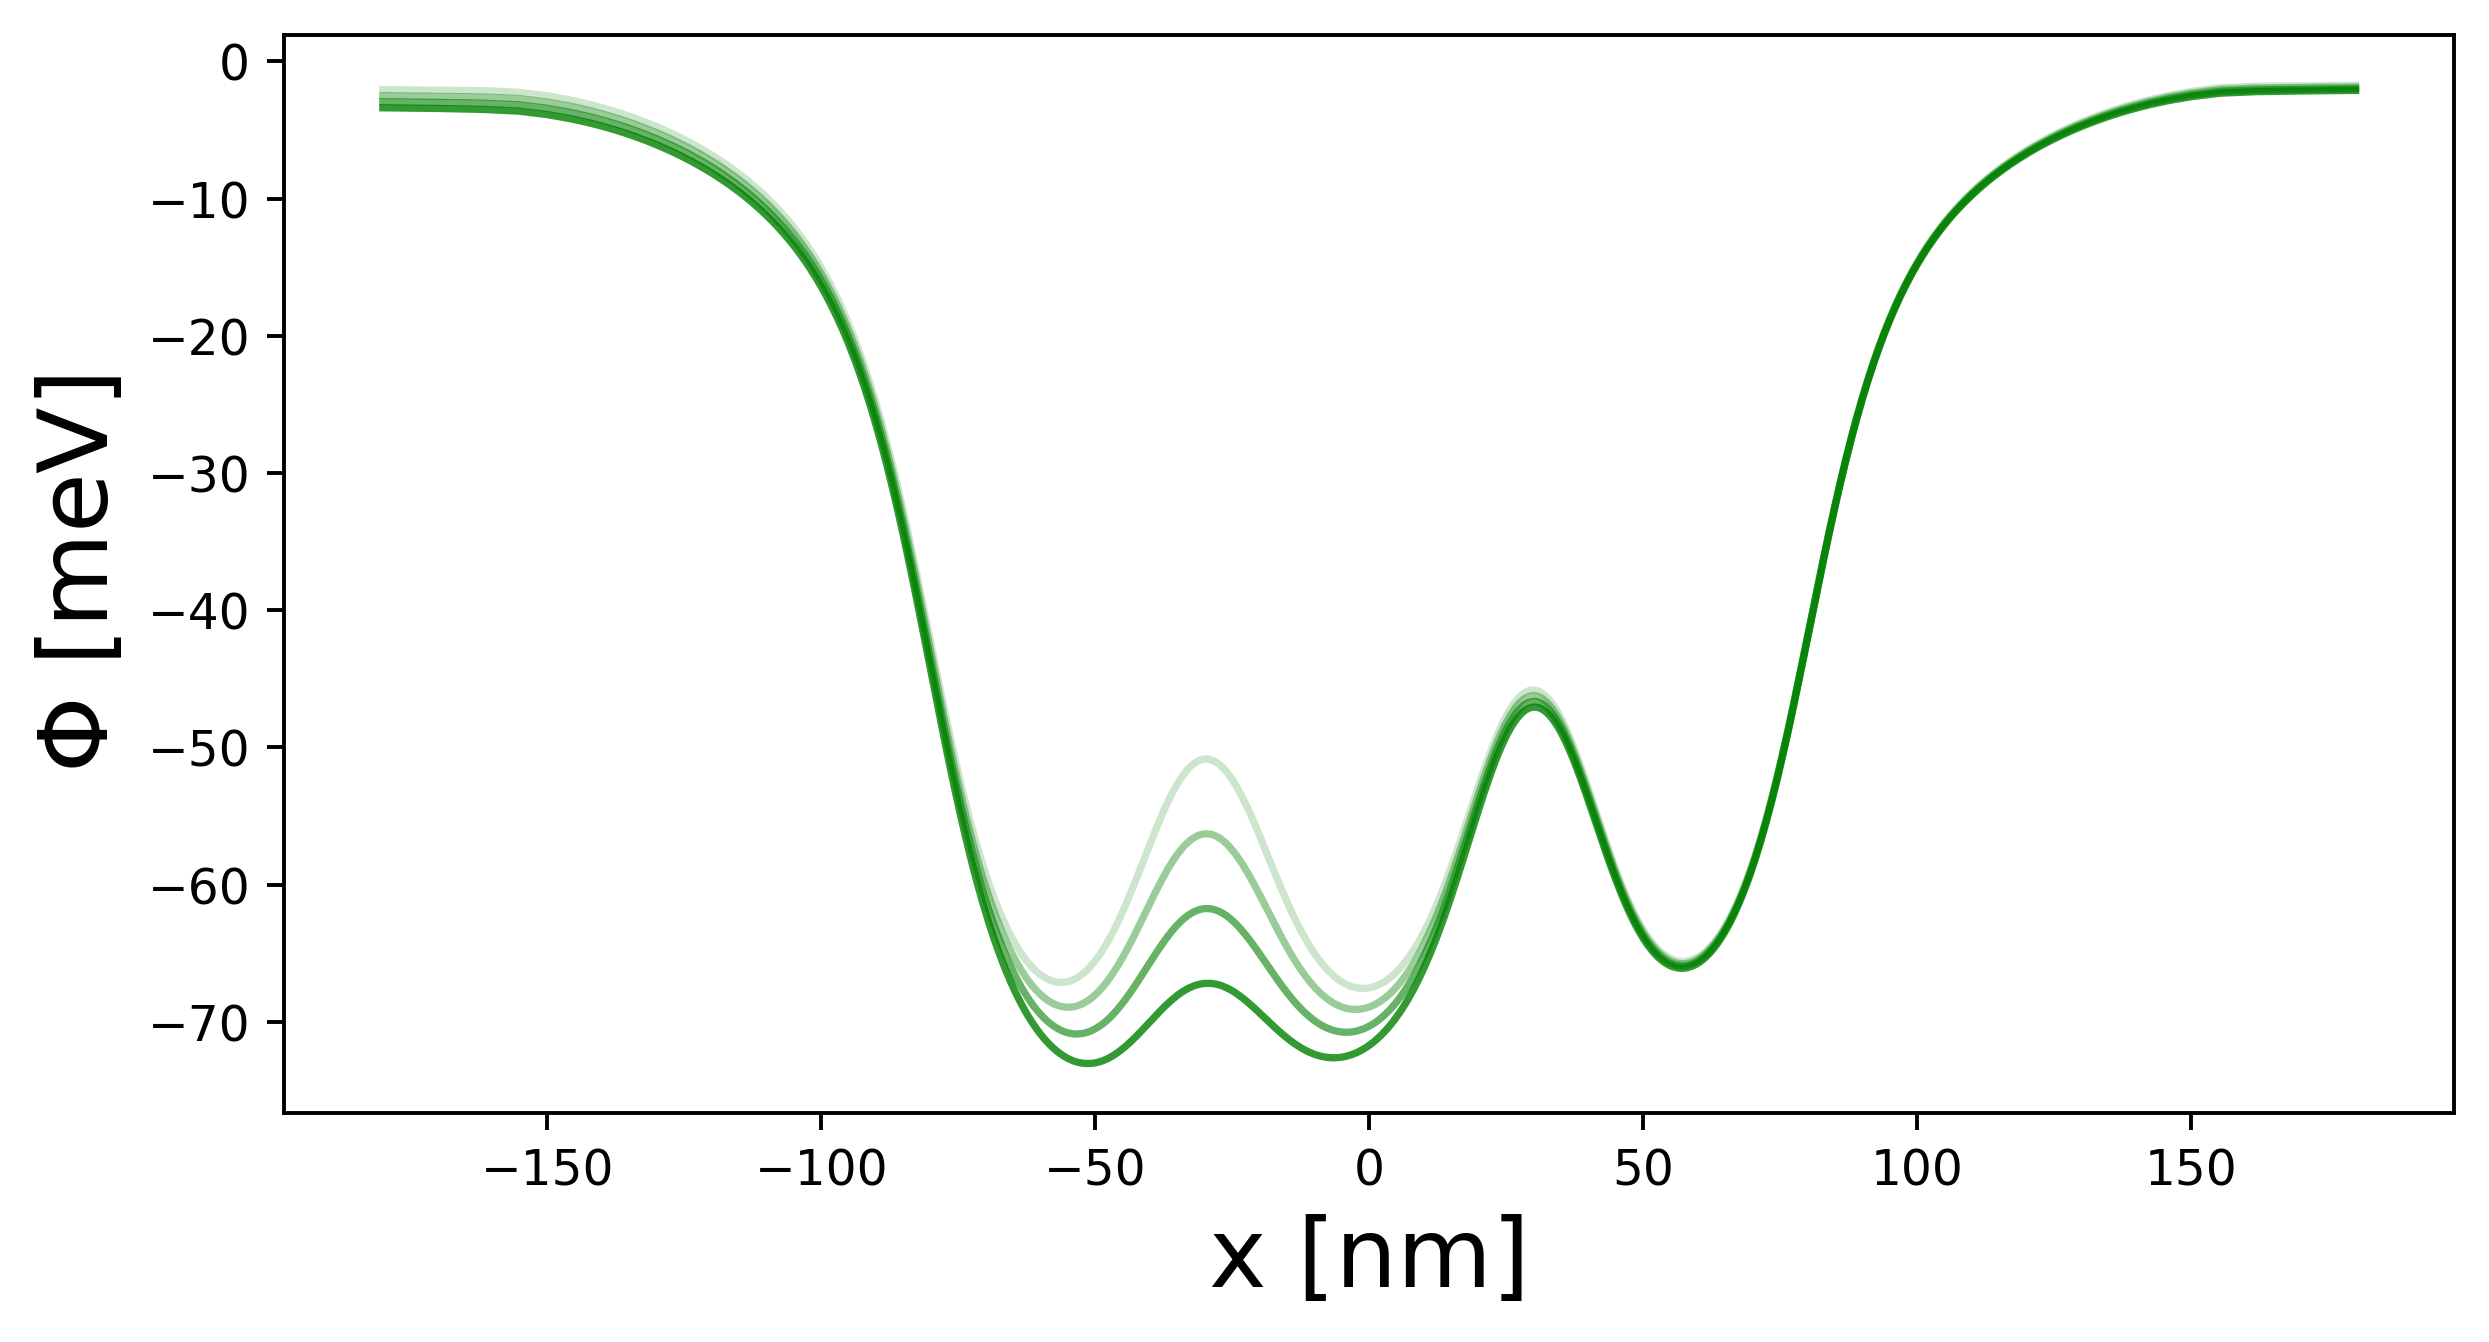

In [19]:
voltage_config = [0.2,0.0,0.35,0.0,0.2]

field_units = 1e-7 # kV/cm -> kV/nm
pot_units = 1/1.622e-19*1e3 # V -> meV
coord_units = 1e9 # m -> nm
wave_units = 1e-9 # 1/m -> 1/nm

pot = dot2.potential(voltage_config)
pot_slice = pot[60,:]
x = dots.x
y = dots.y

steps = 5
v = np.linspace(0,0.125, steps)
fig, ax = plt.subplots(figsize=(8,4), dpi=350)

for idx, volt in  enumerate(v):
    voltage_config = [0.218,volt,0.2,0.0,0.218]
    
    pot = dots.potential(voltage_config)
    pot_masked = dot2.potential(voltage_config)
    field = dots.e_field(voltage_config)
    field_masked = dot2.e_field(voltage_config)

    e_max = np.max(field)
    p_max = np.max(pot)
    pot -= p_max
    field -= e_max

    pot_slice = pot[60]
    pot_masked_slice = pot_masked[60]

    phi, = ax.plot(x*coord_units, pot_slice * pot_units, '-g', alpha=idx/steps)

font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 20,
        }

ax.set_ylabel('$\Phi$ [meV]', fontdict=font)
ax.set_xlabel('x [nm]', fontdict=font)